## Dependencies

In [74]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

In [75]:
# Python SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.types import Integer, Text, String, DateTime, Float
import psycopg2

In [76]:
# Store tax revenue csv into a dataframe
tax_revenue_file = "./Data/Cannabis_Tax_Revenue_Growth.csv"
tax_revenue_df = pd.read_csv(tax_revenue_file)

# Set index
# tax_revenue_df.set_index("state", inplace=True)
tax_revenue_df = tax_revenue_df.sort_values('revenue_2019')

In [77]:
# Store drug death csv into a dataframe
drug_death_file = "./Data/Drug_Death_Report_kaggle.csv"
drug_death_df = pd.read_csv(drug_death_file)

# Filtered dataframe
drug_death_cols = ["state", "year", "drug_deaths", "population"]
deaths_transformed = drug_death_df[drug_death_cols].copy()
deaths_transformed['state'] = deaths_transformed['state'].str.rstrip()

In [78]:
# Store state legal status csv into a dataframe
state_status_file = "./Data/states_statuses_dolthub.csv"
state_status_df = pd.read_csv(state_status_file)

# Filtered dataframe
state_status_cols = ["state", "medical", "recreational", "illegal"]
state_status_transformed = state_status_df[state_status_cols].copy()

In [79]:
# Store state recreational use of cannabis csv into a dataframe
st_rec_use_file = "./Data/State_Rec_Use_Of_Cannabis_NIH_1.csv"
st_rec_use_df = pd.read_csv(st_rec_use_file)

# Filtered dataframe
st_rec_use_cols = ["jurisdiction", "date_begin", "date_end",
                   "recreational_use_legalized"]
st_rec_use_transformed = st_rec_use_df[st_rec_use_cols].copy()

# Drop nan and set index
# st_rec_use_transformed = st_rec_use_transformed.dropna()
# st_rec_use_transformed = st_rec_use_transformed.set_index("jurisdiction")

st_rec_use_transformed['date_begin'] = st_rec_use_transformed['date_begin'].fillna('01/01/2011')
st_rec_use_transformed['recreational_use_legalized'] = st_rec_use_transformed['recreational_use_legalized'].fillna('No')
st_rec_use_transformed['date_begin'] = pd.to_datetime(st_rec_use_transformed['date_begin'])
st_rec_use_transformed['date_end'] = pd.to_datetime(st_rec_use_transformed['date_end'])

In [80]:
# Database Connection
connection_string = "postgres:postgres@localhost:5432/etl_project"
engine = create_engine(f'postgresql://{connection_string}')

In [81]:
# Confirm tables
engine.table_names()

['tax_revenue', 'state_deaths', 'state_status', 'rec_use']

In [82]:
tax_revenue_df.to_sql(
                name="tax_revenue",
                con=engine,
                if_exists='replace',
                index=False,
                dtype={"state": String,
                       "2018_revenue": Float,
                       "2018_revenue_share": Float,
                       "revenue_2019": Float,
                       "2019_revenue_share": Float,
                       "rev_growth_18_19": Float,
                       "usa_growth_share": Float
                        }
)

In [83]:
deaths_transformed.to_sql(
                name="state_deaths",
                con=engine,
                if_exists='replace',
                index=False,
                dtype={"state": Text,
                       "year": Integer,
                       "drug_deaths": Integer,
                       "population": Integer,
                }
)

In [84]:
state_status_df.to_sql(
                name="state_status",
                con=engine,
                if_exists='replace',
                index=False,
                dtype={"state": Text,
                       "medical": Text,
                       "recreational": Text,
                       "illegal": Text,
                }
)

In [85]:
st_rec_use_transformed.to_sql(
                name="rec_use",
                con=engine,
                if_exists='replace',
                index=False,
                dtype={"jurisdiction": Text,
                       "date_begin": DateTime,
                       "date_end": DateTime,
                       "recreational_use_legalized": Text, 
                       "tax_imposed": Text
                }
)

In [86]:
sorted_st_rec = st_rec_use_transformed.sort_values(['jurisdiction','date_begin'])
# grouped_st_rec.head()

In [87]:
# Count legal states by years
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
counts = []

for year in years:
    date_year = f"{year}-01-01"
    year_df = sorted_st_rec[(date_year >= sorted_st_rec['date_begin']) 
                             & (date_year <= sorted_st_rec['date_end']) 
                             & (sorted_st_rec['recreational_use_legalized'] == 'Yes')]
    counts.append(year_df['jurisdiction'].count())

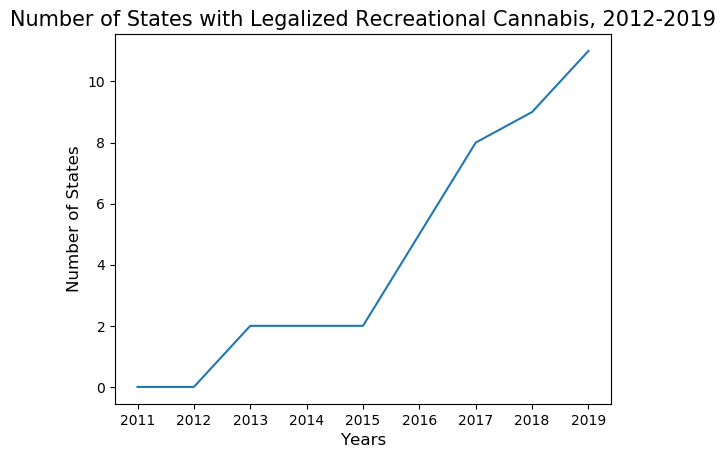

In [88]:
plt.xlabel("Years", size=12)
plt.ylabel("Number of States", size= 12)
plt.title(f"Number of States with Legalized Recreational Cannabis, 2012-2019", size=15)
plt.plot(years, counts)
plt.show()

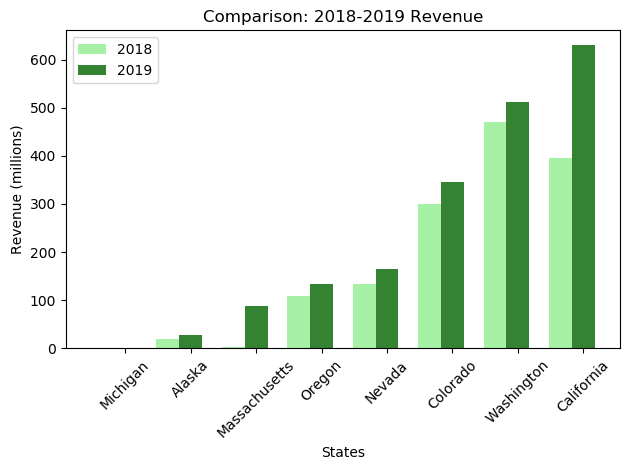

In [89]:
# Plot 2018-2019 Tax Revenue

# data to plot
n_groups = tax_revenue_df['state'].count()
revs_18 = tax_revenue_df['2018_revenue']
revs_19 = tax_revenue_df['revenue_2019']

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, revs_18, bar_width,
alpha=opacity,
color='lightgreen',
label='2018')

rects2 = plt.bar(index + bar_width, revs_19, bar_width,
alpha=opacity,
color='darkgreen',
label='2019')

plt.xlabel('States')
plt.ylabel('Revenue (millions)')
plt.title('Comparison: 2018-2019 Revenue')
plt.xticks(index + bar_width, tax_revenue_df['state'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [90]:
# Plot Drug Deaths
# deaths_transformed

# Count states by years
years = [2011, 2012, 2013, 2014, 2015, 2016]

for year in years:
    date_year = f"{year}-01-01"
    year_df = sorted_st_rec[(date_year >= sorted_st_rec['date_begin']) 
                             & (date_year <= sorted_st_rec['date_end']) 
                             & (sorted_st_rec['recreational_use_legalized'] == 'Yes')]
#    print(year_df)

In [91]:
sorted_st_rec['year'] = pd.DatetimeIndex(sorted_st_rec['date_begin']).year
sorted_st_rec.head()

,jurisdiction,date_begin,date_end,recreational_use_legalized,year
0,Alaska,2012-01-01,2015-02-23,No,2012
1,Alaska,2015-02-24,2015-05-04,Yes,2015
2,Alaska,2015-05-05,2016-02-20,Yes,2015
3,Alaska,2016-02-21,2016-05-27,Yes,2016
4,Alaska,2016-05-28,2018-12-31,Yes,2016


In [92]:
sorted_st_rec = sorted_st_rec[['jurisdiction', 'year', 'recreational_use_legalized']]
sorted_st_rec = sorted_st_rec[sorted_st_rec['recreational_use_legalized'] == 'Yes']
sorted_rec = sorted_st_rec.groupby('jurisdiction')
legalized_states = sorted_rec.min()
legalized_states = legalized_states[legalized_states['year'] <= 2015]
legalized_states

,year,recreational_use_legalized
jurisdiction,,
Alaska,2015,Yes
Colorado,2012,Yes
District of Columbia,2015,Yes
Oregon,2015,Yes
Washington,2012,Yes


In [93]:
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016]
states = legalized_states.index.tolist()

deaths_transformed = deaths_transformed[deaths_transformed['state'].isin(states)]
deaths_transformed = deaths_transformed[deaths_transformed['year'].isin(years)]
deaths_transformed['death_percent'] = deaths_transformed['drug_deaths'] / deaths_transformed['population']
deaths_transformed

,state,year,drug_deaths,population,death_percent
29,Alaska,2010,84,710231,0.000118
30,Alaska,2011,107,722718,0.000148
31,Alaska,2012,132,731449,0.000180
32,Alaska,2013,110,735132,0.000150
33,Alaska,2014,127,736732,0.000172
34,Alaska,2015,127,738432,0.000172
35,Alaska,2016,138,741894,0.000186
101,Colorado,2010,676,5029196,0.000134
102,Colorado,2011,852,5116796,0.000167
103,Colorado,2012,826,5187582,0.000159


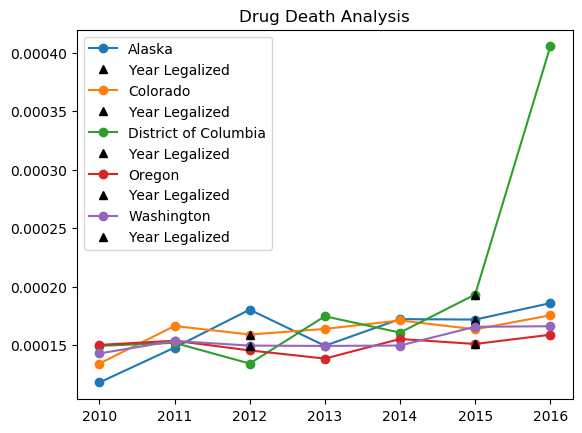

In [94]:
# Plot Results
for state in states:
    state_to_plot = deaths_transformed[deaths_transformed['state'] == state]
    x = years
    y = state_to_plot['death_percent']
    
    # Plot the world average as a line chart
    plt.plot(x, y, "-o", label=state)
    state_legalized_record = legalized_states.loc[state]
    
    # state_legalized_record.head()
    year_legalized = state_legalized_record['year']
    df = deaths_transformed[(deaths_transformed['state'] == state) & (deaths_transformed['year'] == year_legalized)] 
    state_death_percent = df['death_percent'].values[0]
    plt.plot(year_legalized, state_death_percent, "^", color='black', label='Year Legalized')
    
# Create a legend
plt.legend()
plt.title("Drug Death Analysis")

# Show the chart
plt.show()

In [ ]:
# Save Image
plt.savefig("./Images/drug_deaths.png")
plt.show()

In [ ]:
# Create map with Geopandas
shp_path = "./Images/cb_2018_us_nation_5m.shp"
map_df = gpd.read_file(shp_path)
state_status_df